In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [2]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [3]:
paths = []
y = []

DATASET_PATH = 'data'

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.wav'):
            parts = file.split('-')
            emotion_code = parts[2]
            emotion_label = emotion_map.get(emotion_code)
            filepath = os.path.join(root, file)
            paths.append(filepath)
            y.append(emotion_label)


In [4]:
import librosa as lr
import numpy as np
import random
import librosa.effects as lefx

def extract_feature(file_path, augment=True):
    # Load audio file, convert to mono, resample for speed
    audio, sample_rate = lr.load(file_path)

    if augment:
        if random.random() < 0.5:
            n_steps = random.choice([-2, -1, 1, 2])
            audio = lefx.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)
        if random.random() < 0.5:
            rate = random.uniform(0.85, 1.15)
            try:
                audio = lefx.time_stretch(audio, rate=rate)
            except:
                pass  # Stretching sometimes fails if audio is short

    # 🎤 MFCCs (Mel-Frequency Cepstral Coefficients)
    # Describes *how* the sound feels to the ear — tone & texture.
    mfccs = np.mean(lr.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0)

    # 🔊 Energy (Root Mean Square)
    # Measures how loud or intense the voice is.
    energy = np.mean(lr.feature.rms(y=audio).T, axis=0)

    # 🎼 Chroma STFT (Short-Time Fourier Transform)
    # Captures pitch class (like musical notes); useful for emotion in melodic speech.
    chroma = np.mean(lr.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)

    # ⚡ Zero Crossing Rate
    # Counts how often the signal changes sign — chaotic speech = more crossings.
    zcr = np.mean(lr.feature.zero_crossing_rate(y=audio).T, axis=0)

    # 📍 Spectral Centroid
    # Tells where the "center of mass" of the sound spectrum is — higher = brighter sound.
    centroid = np.mean(lr.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0)

    # 📏 Spectral Bandwidth
    # Measures the width of the spectrum — more emotion = wider bandwidth.
    bandwidth = np.mean(lr.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0)

    # 🌈 Spectral Contrast
    # Captures the difference between peaks and valleys in the spectrum — useful for timbre/emotion.
    contrast = np.mean(lr.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)

    # 🪞 Spectral Flatness
    # Measures noisiness — flat = noise-like, sharp = tonal.
    flatness = np.mean(lr.feature.spectral_flatness(y=audio).T, axis=0)

    # 🎚️ Spectral Rolloff
    # Frequency below which most of the energy is contained — relates to tone sharpness.
    rolloff = np.mean(lr.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0)

    # 🔮 Tonnetz (Tonal Centroid)
    # Advanced pitch features — captures harmonic relations; good for emotional musicality in voice.
    tonnetz = np.mean(lr.feature.tonnetz(y=lr.effects.harmonic(audio), sr=sample_rate).T, axis=0)

    # 🧠 Combine all features into a single vector
    return np.hstack([
        mfccs,         # 13 values
        energy,        # 1 value
        chroma,        # 12 values
        zcr,           # 1 value
        centroid,      # 1 value
        bandwidth,     # 1 value
        contrast,      # 7 values
        flatness,      # 1 value
        rolloff,       # 1 value
        tonnetz        # 6 values
    ])


In [5]:
all_features = []

for i in range(len(paths)):
    file_path = paths[i]
    features = extract_feature(file_path)
    all_features.append(features)

# Convert list of arrays into a DataFrame
features_df = pd.DataFrame(all_features, columns=[f'feature_{i}' for i in range(len(all_features[0]))])

features_df['path'] = paths
features_df['emotion'] = y

df = features_df

# Save it
df.to_csv('ravdess_labels.csv', index=False)

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1002
  warnings.warn(
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1013
  warnings.warn(
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=992
  warnings.warn(
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=972
  warnings.warn(
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=998
  warnings.warn(
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is 

In [6]:
df = pd.read_csv('ravdess_labels.csv')

In [7]:
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# y_encoded = one_hot_encoder.fit_transform(df[['emotion']])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['emotion'])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns=['path', 'emotion']),
    y_encoded,
    test_size=0.2,
    random_state=42
)

In [9]:
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [10]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(x_train_sc, y_train)

selector = SelectFromModel(rf, prefit=True, threshold='mean')

x_train_selected = selector.transform(x_train_sc)
x_test_selected = selector.transform(x_test_sc)

In [11]:
pca = PCA(n_components=10)

x_train_pca = pca.fit_transform(x_train_selected)
x_test_pca = pca.transform(x_test_selected)

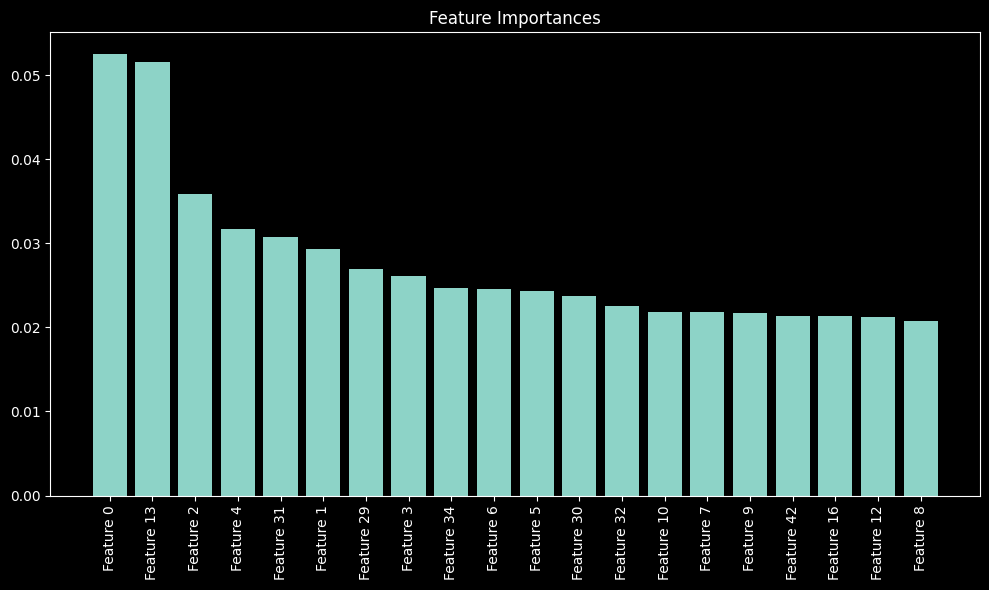

In [12]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 20
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), [f'Feature {i}' for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True, verbose=1)

In [14]:
model = Sequential([
    Input(shape=(x_train_selected.shape[1],)),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dense(8, activation='softmax')  # 8 emotion classes
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_selected, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])

Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 71.


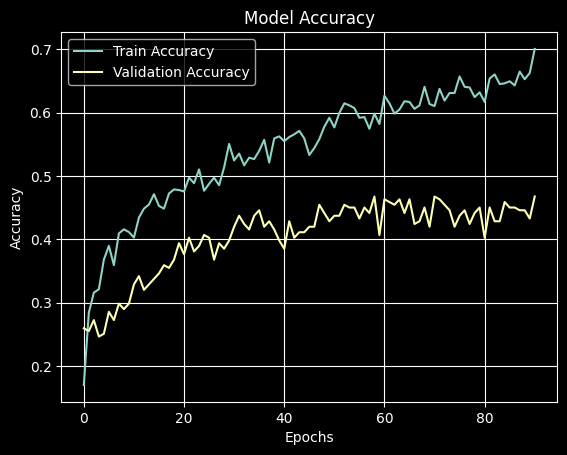

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


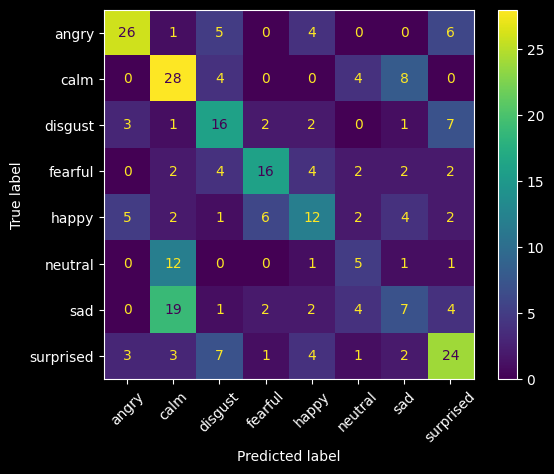

              precision    recall  f1-score   support

       angry       0.70      0.62      0.66        42
        calm       0.41      0.64      0.50        44
     disgust       0.42      0.50      0.46        32
     fearful       0.59      0.50      0.54        32
       happy       0.41      0.35      0.38        34
     neutral       0.28      0.25      0.26        20
         sad       0.28      0.18      0.22        39
   surprised       0.52      0.53      0.53        45

    accuracy                           0.47       288
   macro avg       0.45      0.45      0.44       288
weighted avg       0.47      0.47      0.46       288



In [16]:
y_pred = model.predict(x_test_selected)

cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.xticks(rotation=45)
plt.show()

print(classification_report(y_test, np.argmax(y_pred, axis=1), target_names=label_encoder.classes_))